# Putting it all togather

In [148]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from itertools import combinations

from sklearn.cross_validation import KFold

from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, scale, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.ensemble import RandomForestClassifier

pd.options.mode.chained_assignment = None


In [149]:
def import_data():
    # For .read_csv, always use header=0 when you know row 0 is the header row
    df = pd.read_csv("./data/ElectionsData-full.csv", header=0)

    df['split'] = 0
    indices = KFold(n=len(df), n_folds=5, shuffle=True)._iter_test_indices()
    df['split'][indices.next()] = 1
    df['split'][indices.next()] = 2
    raw_data = df.copy()

    raw_data[raw_data['split'] == 0].drop('split', axis=1).to_csv('./data/output/raw_train.csv', index=False, sep=',')
    raw_data[raw_data['split'] == 1].drop('split', axis=1).to_csv('./data/output/raw_test.csv', index=False, sep=',')
    raw_data[raw_data['split'] == 2].drop('split', axis=1).to_csv('./data/output/raw_validation.csv', index=False)

    return df

df_old = import_data()
df_old.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 39 columns):
Vote                                             10000 non-null object
Occupation_Satisfaction                          9809 non-null float64
Avg_monthly_expense_when_under_age_21            9809 non-null float64
AVG_lottary_expanses                             9818 non-null float64
Most_Important_Issue                             9909 non-null object
Avg_Satisfaction_with_previous_vote              9829 non-null float64
Looking_at_poles_results                         9909 non-null object
Garden_sqr_meter_per_person_in_residancy_area    9794 non-null float64
Married                                          9929 non-null object
Gender                                           9928 non-null object
Voting_Time                                      9903 non-null object
Financial_balance_score_(0-1)                    9810 non-null float64
%Of_Household_Income                         

# Loading the new data

In [150]:
df_new = pd.read_csv('./data/ElectionsData_Pred_Features.csv', header=0)
df_new['split'] = 3


In [151]:
train_split = 0
test_split = 1
validation_split = 2
new_split = 3

In [152]:
df_new["%Of_Household_Income"] = df_new["X.Of_Household_Income"]
df_new["%Time_invested_in_work"] = df_new["X.Time_invested_in_work"]
df_new["%_satisfaction_financial_policy"] = df_new["X._satisfaction_financial_policy"]
df_new["Financial_balance_score_(0-1)"] = df_new["Financial_balance_score_.0.1."]

df_new.drop(['X.Of_Household_Income', 'X.Time_invested_in_work', 'X._satisfaction_financial_policy', 'Financial_balance_score_.0.1.'],inplace=True, axis=1)

In [153]:
df_all = df_new.append(df_old, ignore_index=True)

df_Votes = df_all['Vote']
df_Ids = df_all['IdentityCard_Num']
df_split = df_all['split']

df_all = df_all.drop(['IdentityCard_Num', 'Vote','split'], axis=1)


In [154]:
def group_features(_df):
    _df = _df.dropna()
    all_features = _df.columns
    categorical_features = _df.select_dtypes(include=["object"])
    numeric_features = _df.select_dtypes(exclude=["object"])

    return [all_features, categorical_features.columns, numeric_features.columns]

all_features, categorical_features, numeric_features = group_features(df_all)


In [155]:
def rows_with_nan(_df):
    return Counter(_df.isnull().sum(axis=1).tolist())

def plot_rows_with_nan(_df, name=""):
    counter = rows_with_nan(_df)
    labels, histogram = zip(*counter.most_common())
    fig1, ax1 = plt.subplots()
    ax1.pie(histogram, labels=labels,
            colors = ['green', 'yellowgreen', 'yellow','orange', 'red'],
            autopct = lambda(p): '{:.0f}  ({:.2f}%)'.format(p * sum(histogram) / 100, p))
    ax1.axis('equal')
    plt.title(name)
    plt.show()
    

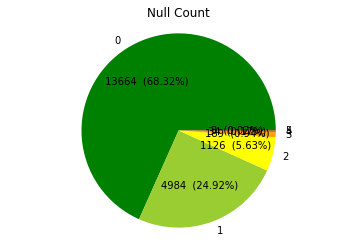

In [156]:
plot_rows_with_nan(df_all, "Null Count")


240
127


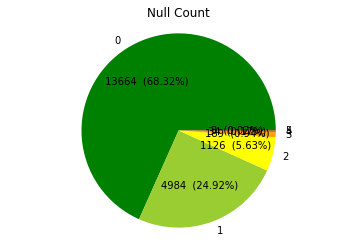

In [157]:
## TODO MAKE THIS WORK

most_important_issue_dic = {
    'Military' : 30.0,
    'Healthcare' : 80.0,
    'Environment' : 90.0,
    'Financial' : 60.0,
    'Education': 100.0,
    'Foreign_Affairs': 40.0,
    'Social':70.0,
    'Other': 50.0
}


def fill_most_important_issue_and_grades2(df_all, most_important_issue_dic):
    for k, v in most_important_issue_dic.iteritems():
        ks = df_all[df_all['Most_Important_Issue'] == k]
        ks['Last_school_grades'] = v
              
        vs = df_all[df_all['Last_school_grades'] == v]
        vs['Most_Important_Issue'] = k
    

print len(df_all[pd.isnull(df_all['Last_school_grades'])])    
print len(df_all[pd.isnull(df_all['Most_Important_Issue'])])    

    
fill_most_important_issue_and_grades2(df_all, most_important_issue_dic)
plot_rows_with_nan(df_all, "Null Count")


In [158]:
def fill_numeric_features(_df, features):
    for f in features:
        _df[f + "_fill"].fillna(_df[f + "_fill"].median(), inplace=True)


def fill_numeric_by_correlation(_df, factor, features):
    cor = _df[features].dropna().corr()
    print "We choose " + str(factor) + " correlation as correlated"
    indices = np.where(cor > factor)
    indices = [(cor.index[x], cor.columns[y], cor.loc[cor.index[x],cor.columns[y]]) for x, y in zip(*indices) if  x < y]
    indices = sorted(indices, key=lambda pair: pair[2], reverse=True)
    for pair in indices:
        fill_f1_with_f2(_df, pair[0], pair[1], pair[2])


def fill_f1_with_f2(_df, f1, f2, val):
    ratio = _df[f1].mean() / _df[f2].mean()
    print 'Filling ' + f1 + ' with ' + f2 + ' due to correlation of %f'% val
    for index, row in _df[_df[f1 + "_fill"].isnull()].iterrows():
        if ~np.isnan(_df[f2][index]):
            _df[f1 + "_fill"][index] = _df[f2][index] * ratio
    
    ratio = _df[f2].mean() / _df[f1].mean()
    print 'Filling ' + f2 + ' with ' + f1 + ' due to correlation %f'% val
    for index, row in _df[_df[f2 + "_fill"].isnull()].iterrows():
        if ~np.isnan(_df[f1][index]):
            _df[f2 + "_fill"][index] = _df[f1][index] * ratio

def remove_fill(_df, features):
    for f in features:
        _df[f] = _df[f + "_fill"]
        del _df[f + "_fill"]

def create_fill(_df, features):
    for f in features:
        _df[f + "_fill"] = _df[f]

********************************************************************************
We choose 0.7 correlation as correlated
Filling Avg_Satisfaction_with_previous_vote with Avg_monthly_expense_when_under_age_21 due to correlation of 1.000000
Filling Avg_monthly_expense_when_under_age_21 with Avg_Satisfaction_with_previous_vote due to correlation 1.000000
Filling Avg_monthly_expense_on_pets_or_plants with Garden_sqr_meter_per_person_in_residancy_area due to correlation of 0.990130
Filling Garden_sqr_meter_per_person_in_residancy_area with Avg_monthly_expense_on_pets_or_plants due to correlation 0.990130
Filling Avg_size_per_room with Yearly_IncomeK due to correlation of 0.977712
Filling Yearly_IncomeK with Avg_size_per_room due to correlation 0.977712
Filling Garden_sqr_meter_per_person_in_residancy_area with Phone_minutes_10_years due to correlation of 0.975228
Filling Phone_minutes_10_years with Garden_sqr_meter_per_person_in_residancy_area due to correlation 0.975228
Filling Avg_monthly

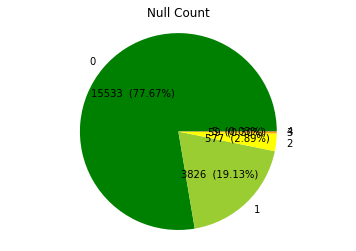

In [159]:
corr_factor = 0.7
print "**" * 40
create_fill(df_all, numeric_features)
fill_numeric_by_correlation(df_all, corr_factor, numeric_features)
remove_fill(df_all, numeric_features)
plot_rows_with_nan(df_all, "Null Count")


%Of_Household_Income
188
%Time_invested_in_work
201
%_satisfaction_financial_policy
209
AVG_lottary_expanses
0
Avg_Residancy_Altitude
188
Avg_Satisfaction_with_previous_vote
0
Avg_education_importance
188
Avg_environmental_importance
224
Avg_government_satisfaction
211
Avg_monthly_expense_on_pets_or_plants
0
Avg_monthly_expense_when_under_age_21
0
Avg_monthly_household_cost
0
Avg_monthly_income_all_years
0
Avg_size_per_room
0
Financial_balance_score_(0-1)
199
Garden_sqr_meter_per_person_in_residancy_area
0
Last_school_grades
198
Num_of_kids_born_last_10_years
220
Number_of_differnt_parties_voted_for
183
Number_of_valued_Kneset_members
209
Occupation_Satisfaction
192
Overall_happiness_score
187
Phone_minutes_10_years
0
Political_interest_Total_Score
0
Weighted_education_rank
207
Yearly_ExpensesK
214
Yearly_IncomeK
0


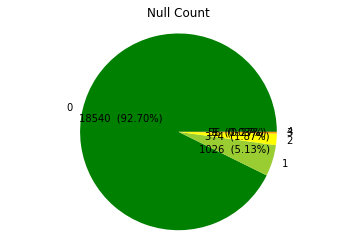

In [160]:
def train_on_feature(df, feature):
    train_data_X = df.drop([feature], axis=1).values
    train_data_Y = df[feature].values
    clf = RandomForestRegressor(n_estimators=50)
      
    return clf.fit(train_data_X, train_data_Y)

def build_clf(df, feature):
    df_tmp = df.copy()
    df_tmp_noNaN = df_tmp.dropna()
    print feature
    print len(df_tmp[pd.isnull(df_tmp[feature])])
    to_predict = df_tmp[pd.isnull(df_tmp[feature])].drop([feature],axis=1)
    clf = train_on_feature(df_tmp_noNaN, feature)
    return to_predict, clf


def fill_numerical(_df, numeric_features):
    results = {}
    df_numeric= _df[numeric_features]
    
    indeces_with_less_than_2_nan = [df_numeric.loc[k].isnull().sum() < 2 for k in df_numeric.index.values]
    df_for_prediction = df_numeric.loc[indeces_with_less_than_2_nan]
    
    for feature in numeric_features:
        to_predict, clf = build_clf(df_for_prediction, feature) 
        if to_predict.shape[0] > 0:           
            results[feature] = zip(to_predict.index.values, clf.predict(to_predict))
    
    #fill in the missing values
    for feature, res in results.iteritems():
        for item in res:
            _df[feature][item[0]] = item[1]
    return _df

fill_numerical(df_all, numeric_features)
plot_rows_with_nan(df_all, "Null Count")

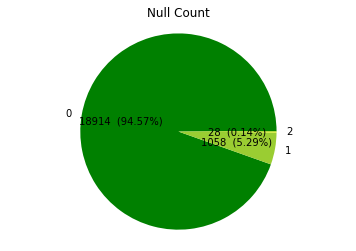

In [161]:
create_fill(df_all, numeric_features)
fill_numeric_features(df_all, numeric_features)
remove_fill(df_all, numeric_features)
plot_rows_with_nan(df_all, "Null Count")

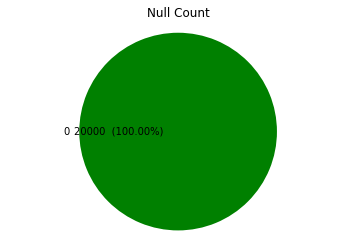

In [162]:
def fill_cat_simple(df, categorical_features):
    for f in categorical_features:
        df[f].fillna(Counter(df[f].dropna()).most_common(1)[0][0], inplace=True)
        
fill_cat_simple(df_all, categorical_features)
plot_rows_with_nan(df_all, "Null Count")


In [163]:
def transform_bool(_df, name):
    _df[name] = _df[name].map({'No': -1, "Maybe": 0, 'Yes': 1}).astype(float)


def transform_category(_df, name):
    for cat in _df[name].unique():
        _df["Is_" + name + "_" + cat] = (_df[name] == cat).astype(float)
    del _df[name]


def transform_manual(_df):
    _df["Age_group"] = _df["Age_group"].map({'Below_30': 0, '30-45': 1, '45_and_up': 2}).astype(float)
    _df["Voting_Time"] = _df["Voting_Time"].map({'By_16:00': 0, 'After_16:00': 1}).astype(float)
    _df["Gender"] = _df["Gender"].map({'Male': -1, 'Female': 1}).astype(float)

    transform_bool(_df, "Looking_at_poles_results")
    transform_bool(_df, "Married")
    transform_bool(_df, "Financial_agenda_matters")
    transform_bool(_df, "Will_vote_only_large_party")
    transform_category(_df, "Most_Important_Issue")
    transform_category(_df, "Occupation")
    transform_category(_df, "Main_transportation")
    
transform_manual(df_all)


In [164]:
def scale_numeric(_df, features):
    for f in features:
        _df[f] = (_df[f] - _df[f].min()) / (_df[f].max() - _df[f].min())
        
scale_numeric(df_all, numeric_features)

In [165]:
df_all.describe()

,%Of_Household_Income,%Time_invested_in_work,%_satisfaction_financial_policy,AVG_lottary_expanses,Age_group,Avg_Residancy_Altitude,Avg_Satisfaction_with_previous_vote,Avg_education_importance,Avg_environmental_importance,Avg_government_satisfaction,...,Is_Most_Important_Issue_Other,Is_Occupation_Hightech,Is_Occupation_Services_or_Retail,Is_Occupation_Industry_or_other,Is_Occupation_Public_Sector,Is_Occupation_Student_or_Unemployed,Is_Main_transportation_Public_or_other,Is_Main_transportation_Motorcycle_or_truck,Is_Main_transportation_Car,Is_Main_transportation_Foot_or_bicycle
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.00000
mean,0.500096,0.502305,0.498935,0.318778,0.999550,0.497648,0.431037,0.501225,0.502888,0.498390,...,0.053750,0.199650,0.196100,0.207350,0.199850,0.19705,0.246900,0.258300,0.248900,0.24590
std,0.284968,0.287280,0.288724,0.094720,0.807826,0.286547,0.136997,0.286725,0.286283,0.287250,...,0.225529,0.399747,0.397055,0.405419,0.399897,0.39778,0.431219,0.437711,0.432387,0.43063
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000
25%,0.256365,0.254788,0.249737,0.260159,0.000000,0.251452,0.333615,0.256727,0.256492,0.248306,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000
50%,0.501970,0.501237,0.496381,0.292746,1.000000,0.497261,0.392980,0.504693,0.502904,0.500058,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000
75%,0.741296,0.749702,0.749856,0.344399,2.000000,0.745580,0.492940,0.745466,0.748352,0.745353,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.00000
max,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.00000


In [166]:
# df_Votes = df_all['Vote']
# df_Ids = df_all['IdentityCard_Num']
# df_split = df_all['split']

df_all['split'] = df_split
df_all['Vote'] = df_Votes
df_all['IdentityCard_Num'] = df_Ids

# train_split = 0
# test_split = 1
# validation_split = 2
# new_split = 3

df_train = df_all[df_all['split'] == train_split]
df_test = df_all[df_all['split'] == test_split]
df_validation = df_all[df_all['split'] == validation_split]

df_init_data = df_all[df_all['split'] != new_split]
df_new = df_all[df_all['split'] == new_split]

In [167]:
df_train_X = df_train.drop(['split', 'Vote', 'IdentityCard_Num'],axis=1)
df_train_Y = df_train['Vote']

df_test_X = df_test.drop(['split', 'Vote', 'IdentityCard_Num'],axis=1)
df_test_Y = df_test['Vote']

df_validation_X = df_validation.drop(['split', 'Vote', 'IdentityCard_Num'],axis=1)
df_validation_Y = df_validation['Vote']

df_init_data_X = df_init_data.drop(['split', 'Vote', 'IdentityCard_Num'],axis=1)
df_init_data_Y = df_init_data['Vote']


df_new_Ids = df_new['IdentityCard_Num']
df_new_X = df_new.drop(['split', 'Vote', 'IdentityCard_Num'],axis=1)


In [168]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

clf = RandomForestClassifier(min_samples_split=6, n_estimators=100, random_state=0)
pred = cross_val_predict(clf, df_train_X.values, df_train_Y.values, cv=30)
print "***** %s *****" % clf.__class__.__name__
print classification_report(df_train_Y.values, pred, digits=5)


clf = RandomForestClassifier(min_samples_split=6, n_estimators=100, random_state=0)
pred = cross_val_predict(clf, df_init_data_X.values, df_init_data_Y.values, cv=30)
print "***** %s *****" % clf.__class__.__name__
print classification_report(df_init_data_Y.values, pred, digits=5)



***** RandomForestClassifier *****
             precision    recall  f1-score   support

      Blues    0.90792   0.98252   0.94374       572
     Browns    0.92150   0.97122   0.94571      1112
     Greens    1.00000   1.00000   1.00000       957
      Greys    0.99359   0.96573   0.97946       321
    Oranges    0.94611   0.94895   0.94753       333
      Pinks    0.95993   0.89984   0.92892       639
    Purples    0.96173   0.97362   0.96764      1213
       Reds    0.95692   0.97188   0.96434       320
     Whites    0.89205   0.75481   0.81771       208
    Yellows    0.96403   0.82462   0.88889       325

avg / total    0.95335   0.95283   0.95221      6000

***** RandomForestClassifier *****
             precision    recall  f1-score   support

      Blues    0.91349   0.98011   0.94563       905
     Browns    0.91963   0.97309   0.94561      1858
     Greens    1.00000   1.00000   1.00000      1629
      Greys    0.99627   0.96915   0.98252       551
    Oranges    0.94353   

In [169]:
fixes_useful_features = [
    'Avg_Satisfaction_with_previous_vote',
    'Number_of_valued_Kneset_members',
    'Yearly_IncomeK',
    'Overall_happiness_score',
    'Avg_monthly_expense_when_under_age_21',
    'Will_vote_only_large_party',
    'Garden_sqr_meter_per_person_in_residancy_area',
    'Is_Most_Important_Issue_Other',
    'Is_Most_Important_Issue_Financial',
    'Is_Most_Important_Issue_Environment',
    'Is_Most_Important_Issue_Military',
    'Is_Most_Important_Issue_Education',
    'Is_Most_Important_Issue_Foreign_Affairs',
    'Is_Most_Important_Issue_Social'
]

df_test_X = df_test_X[fixes_useful_features]
df_train_X = df_train_X[fixes_useful_features]
df_init_data_X = df_init_data_X[fixes_useful_features] 
df_new_X = df_new_X[fixes_useful_features]

clf = RandomForestClassifier(min_samples_split=6, n_estimators=100, random_state=0)
pred = cross_val_predict(clf, df_train_X.values, df_train_Y.values, cv=30)
print "***** %s *****" % clf.__class__.__name__
print classification_report(df_train_Y.values, pred, digits=5)


clf = RandomForestClassifier(min_samples_split=6, n_estimators=100, random_state=0)
pred = cross_val_predict(clf, df_init_data_X.values, df_init_data_Y.values, cv=30)
print "***** %s *****" % clf.__class__.__name__
print classification_report(df_init_data_Y.values, pred, digits=5)



***** RandomForestClassifier *****
             precision    recall  f1-score   support

      Blues    0.90354   0.98252   0.94137       572
     Browns    0.92464   0.98201   0.95246      1112
     Greens    1.00000   0.99478   0.99738       957
      Greys    0.98083   0.95639   0.96845       321
    Oranges    0.93491   0.94895   0.94188       333
      Pinks    0.97479   0.90767   0.94003       639
    Purples    0.97884   0.99176   0.98526      1213
       Reds    0.96845   0.95937   0.96389       320
     Whites    0.93333   0.80769   0.86598       208
    Yellows    0.96337   0.80923   0.87960       325

avg / total    0.95926   0.95833   0.95781      6000

***** RandomForestClassifier *****
             precision    recall  f1-score   support

      Blues    0.90798   0.98122   0.94318       905
     Browns    0.92683   0.98170   0.95348      1858
     Greens    0.99938   0.99632   0.99785      1629
      Greys    0.97782   0.96007   0.96886       551
    Oranges    0.92896   

In [214]:
clf = RandomForestClassifier(min_samples_split=4, n_estimators=200, random_state=0)
clf.fit(df_train_X.values, df_train_Y.values)

pred = clf.predict(df_test_X.values)
distribution = Counter(pred)
print distribution

print "predicted winner is party ## %s ##" % distribution.most_common(1)[0][0]


2000
Counter({'Purples': 455, 'Browns': 394, 'Greens': 330, 'Pinks': 196, 'Blues': 181, 'Oranges': 113, 'Greys': 100, 'Reds': 94, 'Yellows': 89, 'Whites': 48})
predicted winner is party ## Purples ##


In [215]:
def evaluate_miss_rate(target, pred):
    miss_vals = []
    real_vals = []
    toples = []

    miss_count = 0
    for i, j in enumerate(pred):
        if pred[i] != target[i]:
            miss_vals.append(pred[i][0])
            real_vals.append(target[i][0])
            toples.append((pred[i][0],target[i][0]))
            miss_count = miss_count + 1

    print "Total Wrong predictions %d out of %d, hit rate: %f"% (miss_count, target.size, 100 - miss_count/float(target.size) * 100) + '%'
    
evaluate_miss_rate(df_test_Y.values, pred)

Total Wrong predictions 89 out of 2000, hit rate: 95.550000%


In [198]:
clf = RandomForestClassifier(min_samples_split=6, n_estimators=100, random_state=0)
clf.fit(df_init_data_X.values, df_init_data_Y.values)

pred = clf.predict(df_new_X.values)
distribution = Counter(pred)
print distribution

print "predicted winner is party ## %s ##" % distribution.most_common(1)[0][0]


Counter({'Browns': 2362, 'Purples': 2053, 'Pinks': 1224, 'Greens': 1021, 'Blues': 1018, 'Oranges': 722, 'Greys': 595, 'Reds': 402, 'Yellows': 339, 'Whites': 264})
predicted winner is party ## Browns ##


### Looking at the data
checing for nil values

__During this exersice we will try to treat the new data and the validation data the same
Meaning we will do the same operations on both, and than measure our success with the validation data.__

In [ ]:
# a = set(df_new.columns)
# b = set(df_validation.columns)

# print "Only in df_new"
# print "_" * 40
# for f in sorted(a-b):
#     print f

# print "Only in df_validation"
# print "_" * 40
# for f in sorted(b-a):
#     print f

#### Looks like we have broken columns between validation and new data. lets fix that:


In [ ]:
# df_new["%Of_Household_Income"] = df_new["X.Of_Household_Income"]
# df_new["%Time_invested_in_work"] = df_new["X.Time_invested_in_work"]
# df_new["%_satisfaction_financial_policy"] = df_new["X._satisfaction_financial_policy"]
# df_new["Financial_balance_score_(0-1)"] = df_new["Financial_balance_score_.0.1."]

# df_new.drop(['X.Of_Household_Income', 'X.Time_invested_in_work', 'X._satisfaction_financial_policy', 'Financial_balance_score_.0.1.'],inplace=True, axis=1)


## Preprocessing the new data and the Validation set

first, we want to "hide" unwanted colums from each dataset: 
- df_validation - has the "Vote" column 
- df_new - has the "IdentityCard_Num" column.

we will remove those for the data cleansing process, and glue them back after we're done.

In [ ]:
# validation_labels = df_validation['Vote']
# new_data_IDs = df_new['IdentityCard_Num']

# df_validation = df_validation.drop(['Vote'],axis=1)
# df_new = df_new.drop(['IdentityCard_Num'],axis=1)

In [ ]:
def rows_with_nan(_df):
    return Counter(_df.isnull().sum(axis=1).tolist())

def plot_rows_with_nan(_df, name=""):
    counter = rows_with_nan(_df)
    labels, histogram = zip(*counter.most_common())
    fig1, ax1 = plt.subplots()
    ax1.pie(histogram, labels=labels,
            colors = ['green', 'yellowgreen', 'yellow','orange', 'red'],
            autopct = lambda(p): '{:.0f}  ({:.2f}%)'.format(p * sum(histogram) / 100, p))
    ax1.axis('equal')
    plt.title(name)
    plt.show()
    

In [ ]:
plot_rows_with_nan(df_validation, "Validation Null Count")
plot_rows_with_nan(df_new, "New data Null Count")


We can see that the new data has a lot less missing values than the validation data.
This is good, this means that for we are good on the validation data, we will be even better on the new data.

In [ ]:
def group_features(_df):
    _df = _df.dropna()
    all_features = _df.columns
    categorical_features = _df.select_dtypes(include=["object"])
    numeric_features = _df.select_dtypes(exclude=["object"])

    return [all_features, categorical_features.columns, numeric_features.columns]



In [ ]:
all_features, categorical_features, numeric_features = group_features(df_new)


#### Categorial Features

In [ ]:
for f in categorical_features:
    print f

#### Numeric Features

In [ ]:
for f in numeric_features:
    print f

## Helper methods - taken from ex2 - Data cleansing
we will document them once we use them.

In [ ]:

def fill_numeric_features(_df, features):
    for f in features:
        _df[f + "_fill"].fillna(_df[f + "_fill"].median(), inplace=True)


def fill_numeric_by_correlation(_df, factor, features):
    redundant_features = []
    cor = _df[features].dropna().corr()
    print "We choose " + str(factor) + " correlation as correlated"
    indices = np.where(cor > factor)
    indices = [(cor.index[x], cor.columns[y], cor.loc[cor.index[x],cor.columns[y]]) for x, y in zip(*indices) if  x < y]
    indices = sorted(indices, key=lambda pair: pair[2], reverse=True)
    for pair in indices:
        fill_f1_with_f2(_df, pair[0], pair[1], pair[2])
        redundant_features.append(pair[1])
    return redundant_features


def fill_f1_with_f2(_df, f1, f2, val):
    ratio = _df[f1].mean() / _df[f2].mean()
    print 'Filling ' + f1 + ' with ' + f2 + ' due to correlation of %f'% val
    for index, row in _df[_df[f1 + "_fill"].isnull()].iterrows():
        if ~np.isnan(_df[f2][index]):
            _df[f1 + "_fill"][index] = _df[f2][index] * ratio
    
    ratio = _df[f2].mean() / _df[f1].mean()
    print 'Filling ' + f2 + ' with ' + f1 + ' due to correlation %f'% val
    for index, row in _df[_df[f2 + "_fill"].isnull()].iterrows():
        if ~np.isnan(_df[f1][index]):
            _df[f2 + "_fill"][index] = _df[f1][index] * ratio

def remove_fill(_df, features):
    for f in features:
        _df[f] = _df[f + "_fill"]
        del _df[f + "_fill"]

def create_fill(_df, features):
    for f in features:
        _df[f + "_fill"] = _df[f]


In ex2 we showed that Most_Important_Issue is a mupltiplication of Last_school_grades.
lets fill with this info the missing values

In [ ]:
most_important_issue_dic = {
    'Military' : 30.0,
    'Healthcare' : 80.0,
    'Environment' : 90.0,
    'Financial' : 60.0,
    'Education': 100.0,
    'Foreign_Affairs': 40.0,
    'Social':70.0,
    'Other': 50.0
}

def fill_most_important_issue_and_grades(_df ,most_important_issue_dic):
    for k, v in most_important_issue_dic.iteritems():
        ks = _df[_df['Most_Important_Issue'] == k]
        ks['Last_school_grades'].fillna(v,inplace=True)
        
        vs = _df[_df['Last_school_grades'] == v]
        vs['Most_Important_Issue'].fillna(k, inplace=True)
    
        
fill_most_important_issue_and_grades(df_new, most_important_issue_dic)
fill_most_important_issue_and_grades(df_validation, most_important_issue_dic)


In [ ]:
plot_rows_with_nan(df_validation, "Validation Null Count")
plot_rows_with_nan(df_new, "New data Null Count")

We have seen in Ex02 that Looking_at_poles_results is a binary of Will_vote_only_large_party

lets fill the data with this info

In [ ]:
plot_rows_with_nan(df_validation, "Validation Null Count")
plot_rows_with_nan(df_new, "New data Null Count")

First we create a 'fill' column for each numric feature
this column will use us as the temp fillet for the features to prevent wrong data fill due to filling order

In [ ]:
create_fill(df_validation, numeric_features)
create_fill(df_new, numeric_features)


### Using Pearson's Correlation Coefficient

At this stage we are looking for corrlation between features
We've set a threshold of 0.7 for the pearson's correlation coefficient. 
Any two features with a value of that and above will be considered "highly correlated" and will be used to to fill the data by multiplying the value from one column by that ratio and set it to the other.

Since most of the columns are either complete or have at most 1 missing value, this will be a very useful tool.

Our method will start from the most corrlated features till it gets to 0.7.

In [ ]:
corr_factor = 0.7
print "**" * 40
print "VALIDATION"
print "**" * 40
fill_numeric_by_correlation(df_validation, corr_factor, numeric_features)

print "**" * 40
print "NEW DATA"
print "**" * 40
fill_numeric_by_correlation(df_new, corr_factor, numeric_features)

In [ ]:
remove_fill(df_validation, numeric_features)
remove_fill(df_new, numeric_features)

### Lets check the missing values status now
looks like we made an improvment, but there is still a way to go.

In [ ]:
plot_rows_with_nan(df_validation, "Validation Null Count")
plot_rows_with_nan(df_new, "New data Null Count")

In [ ]:
def train_on_feature(df, feature):
    train_data_X = df.drop([feature], axis=1).values
    train_data_Y = df[feature].values
    clf = RandomForestRegressor(n_estimators=50)
      
    return clf.fit(train_data_X, train_data_Y)

def build_clf(df, feature):
    df_tmp = df.copy()
    df_tmp_noNaN = df_tmp.dropna()
    print feature
    print len(df_tmp[pd.isnull(df_tmp[feature])])
    to_predict = df_tmp[pd.isnull(df_tmp[feature])].drop([feature],axis=1)
    clf = train_on_feature(df_tmp_noNaN, feature)
    return to_predict, clf


def fill_numerical(_df, numeric_features):
    results = {}
    df_numeric= _df[numeric_features]
    
    indeces_with_less_than_2_nan = [df_numeric.loc[k].isnull().sum() < 2 for k in df_numeric.index.values]
    df_for_prediction = df_numeric.loc[indeces_with_less_than_2_nan]
    
    for feature in numeric_features:
        to_predict, clf = build_clf(df_for_prediction, feature) 
        if to_predict.shape[0] > 0:           
            results[feature] = zip(to_predict.index.values, clf.predict(to_predict))
    
    #fill in the missing values
    for feature, res in results.iteritems():
        for item in res:
            _df[feature][item[0]] = item[1]
    return _df

In [ ]:
# fill_numerical(df_validation, numeric_features)
# fill_numerical(df_new, numeric_features)

1

### Looks like we are getting closer
now all the numeric fields are full.

In [ ]:
plot_rows_with_nan(df_validation, "Validation Null Count")
plot_rows_with_nan(df_new, "New data Null Count")

In [ ]:
# from fancyimpute import SoftImpute

# def complete_fancy_impute(_df, features):
#     data_no_cat = _df.drop(categorical_features, axis=1)
#     completed = SoftImpute().complete(data_no_cat)
#     print completed
# #     _df[data_no_cat.columns] = completed
#     plot_pie_nan_per_row(df)

# complete_fancy_impute(df_validation)

### Lets go for categorial now

In [ ]:
# def transform_bool(_df, name):
#     _df[name] = _df[name].map({'No': -1, "Maybe": 0, 'Yes': 1}).astype(int)


# def transform_category(_df, name):
#     for cat in _df[name].unique():
#         _df["Is_" + name + "_" + cat] = (_df[name] == cat).astype(int)
#     del _df[name]

# def transform_manual(_df):
#     _df["Age_group"] = _df["Age_group"].map({'Below_30': 0, '30-45': 1, '45_and_up': 2}).astype(int)
#     _df["Voting_Time"] = _df["Voting_Time"].map({'By_16:00': 0, 'After_16:00': 1}).astype(int)
#     _df["Gender"] = _df["Gender"].map({'Male': -1, 'Female': 1}).astype(int)

#     transform_bool(_df, "Looking_at_poles_results")
#     transform_bool(_df, "Married")
#     transform_bool(_df, "Financial_agenda_matters")
#     transform_bool(_df, "Will_vote_only_large_party")
#     transform_category(_df, "Most_Important_Issue")
#     transform_category(_df, "Occupation")
#     transform_category(_df, "Main_transportation")

# def transform_for_predicrtion(_df):
#     _df["Age_group"] = _df["Age_group"].map({'Below_30': 0, '30-45': 1, '45_and_up': 2}).astype(int)
#     _df["Voting_Time"] = _df["Voting_Time"].map({'By_16:00': 0, 'After_16:00': 1}).astype(int)
#     _df["Gender"] = _df["Gender"].map({'Male': -1, 'Female': 1}).astype(int)

#     transform_bool(_df, "Looking_at_poles_results")
#     transform_bool(_df, "Married")
#     transform_bool(_df, "Financial_agenda_matters")
#     transform_bool(_df, "Will_vote_only_large_party")

# def drop_if_exists(_df, column):
#     if column in _df.columns:
#         _df.drop([column], inplace=True, axis=1)
    
# def train_on_feature_cat(df, feature):
#     df_transformed = df.copy()
#     transform_for_predicrtion(df_transformed)
    
#     train_data_Y = df_transformed[feature].values
#     drop_if_exists(df_transformed, "Most_Important_Issue")
#     drop_if_exists(df_transformed, "Occupation")
#     drop_if_exists(df_transformed, "Main_transportation")
#     drop_if_exists(df_transformed, feature)

#     print df_transformed.info()
#     train_data_X = df_transformed.values
#     print train_data_Y

#     clf = RandomForestClassifier(n_estimators=50)
#     return clf.fit(train_data_X, train_data_Y)

# def build_clf_cat(df, feature):
#     df_tmp = df.copy()
#     df_tmp_noNaN = df_tmp.dropna()
    
#     to_predict = df_tmp[pd.isnull(df_tmp[feature])].drop([feature],axis=1)
    
#     to_predic_transformed = transform_for_predicrtion(df_tmp)
#     drop_if_exists(to_predic_transformed, "Most_Important_Issue")
#     drop_if_exists(to_predic_transformed, "Occupation")
#     drop_if_exists(to_predic_transformed, "Main_transportation")
    
    
#     clf = train_on_feature_cat(df_tmp_noNaN, feature)
#     return to_predic_transformed, clf


# def fill_cat(_df, categorial_features):
#     results = {}
    
#     indeces_with_less_than_2_nan = [_df.loc[k].isnull().sum() < 2 for k in _df.index.values]
#     df_for_prediction = _df.loc[indeces_with_less_than_2_nan]
    
#     for feature in categorial_features:
#         print feature
#         to_predict, clf = build_clf_cat(df_for_prediction, feature) 
#         if to_predict.shape[0] > 0:           
#             results[feature] = zip(to_predict.index.values, clf.predict(to_predict))
    
#     #fill in the missing values
#     for feature, res in results.iteritems():
#         for item in res:
#             _df[feature][item[0]] = item[1]
#     return _df

In [ ]:
def fill_cat_simple(df, categorical_features):
    for f in categorical_features:
        df[f].fillna(Counter(df[f].dropna()).most_common(1)[0][0], inplace=True)

def fill_numeric_simple(df, numeric_features):
    for f in numeric_features:
        df[f].fillna(df[f].mean(), inplace=True)



In [ ]:
fill_cat_simple(df_validation, categorical_features)
fill_numeric_simple(df_validation, numeric_features)

fill_cat_simple(df_new, categorical_features)
fill_numeric_simple(df_new, numeric_features)

In [ ]:
plot_rows_with_nan(df_validation, "Validation Null Count")
plot_rows_with_nan(df_new, "New data Null Count")

# Looks like we are done with data imputation
### Now we can transform and scale the data
#### Lets look what we have

In [ ]:
df_validation.info()

#### Now lets transform the categorial features to numric values

In [ ]:
def transform_bool(_df, name):
    _df[name] = _df[name].map({'No': -1, "Maybe": 0, 'Yes': 1}).astype(int)


def transform_category(_df, name):
    for cat in _df[name].unique():
        _df["Is_" + name + "_" + cat] = (_df[name] == cat).astype(int)
    del _df[name]


def transform_manual(_df):
    _df["Age_group"] = _df["Age_group"].map({'Below_30': 0, '30-45': 1, '45_and_up': 2}).astype(int)
    _df["Voting_Time"] = _df["Voting_Time"].map({'By_16:00': 0, 'After_16:00': 1}).astype(int)
    _df["Gender"] = _df["Gender"].map({'Male': -1, 'Female': 1}).astype(int)

    transform_bool(_df, "Looking_at_poles_results")
    transform_bool(_df, "Married")
    transform_bool(_df, "Financial_agenda_matters")
    transform_bool(_df, "Will_vote_only_large_party")
    transform_category(_df, "Most_Important_Issue")
    transform_category(_df, "Occupation")
    transform_category(_df, "Main_transportation")
    
transform_manual(df_validation)
transform_manual(df_new)
                 

#### Now lets scale all the numeric features

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

# df_new.describe()
def scale_numeric(_df, features):
    for f in features:
        _df[f] = (_df[f] - _df[f].min()) / (_df[f].max() - _df[f].min())
        
scale_numeric(df_validation, numeric_features)
scale_numeric(df_new, numeric_features)



In [ ]:
df_new.info()

In [ ]:
fixes_useful_features = [ #fixed
    'Avg_Satisfaction_with_previous_vote',
    'Number_of_valued_Kneset_members',
    'Yearly_IncomeK',
    'Overall_happiness_score',
    'Avg_monthly_expense_when_under_age_21',
    'Will_vote_only_large_party',
    'Garden_sqr_meter_per_person_in_residancy_area',
    'Is_Most_Important_Issue_Other',
    'Is_Most_Important_Issue_Financial',
    'Is_Most_Important_Issue_Environment',
    'Is_Most_Important_Issue_Military',
    'Is_Most_Important_Issue_Education',
    'Is_Most_Important_Issue_Foreign_Affairs',
    'Is_Most_Important_Issue_Social',
    'Weighted_education_rank'
]

fixes_useful_features = [
    'Avg_Satisfaction_with_previous_vote',
    'Number_of_valued_Kneset_members',
    'Yearly_IncomeK',
    'Overall_happiness_score',
    'Avg_monthly_expense_when_under_age_21',
    'Will_vote_only_large_party',
    'Garden_sqr_meter_per_person_in_residancy_area',
    'Is_Most_Important_Issue_Other',
    'Is_Most_Important_Issue_Financial',
    'Is_Most_Important_Issue_Environment',
    'Is_Most_Important_Issue_Military',
    'Is_Most_Important_Issue_Education',
    'Is_Most_Important_Issue_Foreign_Affairs',
    'Is_Most_Important_Issue_Social'
]

In [ ]:
df_validation['Vote'] = validation_labels
df_validation[fixes_useful_features + ['Vote']].to_csv('./data/output/validation_fixed.csv', index=False, sep=',')
df_validation_clean = df_validation[fixes_useful_features]
df_new['IdentityCard_Num'] = new_data_IDs
df_new[fixes_useful_features + ['IdentityCard_Num']].to_csv('./data/output/new_fixed.csv', index=False, sep=',')
df_new_clean = df_new[fixes_useful_features]

# WE ARE DONE WITH PART ONE - DATA PREPERATION

### Now we load the data we prepared in previous excerces
We will use train and test data for training.

We will use valdation data to measure our prediction.



In [ ]:
df_train_X, df_train_Y, df_test_X, df_test_Y, labels = load_prepared_data()
df_train_Y_nums = df_train_Y
df_test_Y_nums = df_test_Y
df_train_Y = df_train_Y.map(lambda x: labels[int(x)])
df_test_Y = df_test_Y.map(lambda x: labels[int(x)])

# df_train_X = df_train_X.append(df_test_X)
# df_train_Y = df_train_Y.append(df_test_Y)

train_val_data = pd.concat([df_train_X])
features = train_val_data.values
labels = pd.concat([df_train_Y]).values


features_test = df_validation_clean



In [ ]:
df_train_X, df_train_Y, df_test_X, df_test_Y, labels = load_prepared_data()
df_train_Y_nums = df_train_Y
df_test_Y_nums = df_test_Y
df_train_Y = df_train_Y.map(lambda x: labels[int(x)])
df_test_Y = df_test_Y.map(lambda x: labels[int(x)])

train_val_data = pd.concat([df_train_X])
features = train_val_data.values
target = pd.concat([df_train_Y]).values

In [ ]:
for f in df_train_X.columns:
    df_train_X[f].plot(kind='kde')
    df_test_X[f].plot(kind='kde')
    df_validation_clean[f].plot(kind='kde')
    plt.title(f)
    plt.show()

In [ ]:
clf = RandomForestClassifier(min_samples_split=4, random_state=0)
clf.fit(features, target)

In [ ]:
pred = clf.predict(df_test_X)
distribution = Counter(pred)
print distribution
print "predicted winner is party ## %s ##" % distribution.most_common(1)[0][0]
print labels[6]


pred = clf.predict(df_validation_clean)
distribution = Counter(pred)
print distribution
print "predicted winner is party ## %s ##" % distribution.most_common(1)[0][0]
print labels[6]
# distribution = np.bincount(pred.astype('int64'))
# most_common = np.argmax(distribution)

# print "winner is party ## %s ##" % labels[most_common.astype('int')]